<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 2198, '日付': '2022-01-12T08:00:00.000Z'},
 {'小計': 3124, '日付': '2022-01-13T08:00:00.000Z'},
 {'小計': 4051, '日付': '2022-01-14T08:00:00.000Z'},
 {'小計': 4561, '日付': '2022-01-15T08:00:00.000Z'},
 {'小計': 4172, '日付': '2022-01-16T08:00:00.000Z'},
 {'小計': 3719, '日付': '2022-01-17T08:00:00.000Z'},
 {'小計': 5185, '日付': '2022-01-18T08:00:00.000Z'},
 {'小計': 7377, '日付': '2022-01-19T08:00:00.000Z'},
 {'小計': 8638, '日付': '2022-01-20T08:00:00.000Z'},
 {'小計': 9699, '日付': '2022-01-21T08:00:00.000Z'},
 {'小計': 11227, '日付': '2022-01-22T08:00:00.000Z'},
 {'小計': 9468, '日付': '2022-01-23T08:00:00.000Z'},
 {'小計': 8503, '日付': '2022-01-24T08:00:00.000Z'},
 {'小計': 12813, '日付': '2022-01-25T08:00:00.000Z'},
 {'小計': 14086, '日付': '2022-01-26T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-01-22 17:00:00+09:00,2700,0,11227,2022-01-22 17:00:00+09:00
2022-01-23 17:00:00+09:00,2446,0,9468,2022-01-23 17:00:00+09:00
2022-01-24 17:00:00+09:00,2936,0,8503,2022-01-24 17:00:00+09:00
2022-01-25 17:00:00+09:00,2600,0,12813,2022-01-25 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-01-22 17:00:00+09:00,2700,0,11227,2022-01-22 17:00:00+09:00,2091.857143,14643.0,0.0,0.0,7145.285714,50017.0
2022-01-23 17:00:00+09:00,2446,0,9468,2022-01-23 17:00:00+09:00,2190.857143,15336.0,0.0,0.0,7901.857143,55313.0
2022-01-24 17:00:00+09:00,2936,0,8503,2022-01-24 17:00:00+09:00,2317.571429,16223.0,0.0,0.0,8585.285714,60097.0
2022-01-25 17:00:00+09:00,2600,0,12813,2022-01-25 17:00:00+09:00,2415.428571,16908.0,0.0,0.0,9675.000000,67725.0
2022-01-26 17:00:00+09:00,0,0,14086,2022-01-26 17:00:00+09:00,2098.571429,14690.0,0.0,0.0,10633.428571,74434.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-01-12 17:00:00+09:00,964,0,2198,2022-01-12 17:00:00+09:00,652.285714,4566.0,0.0,0.0,1148.714286,8041.0,'22w02,Wed
2022-01-13 17:00:00+09:00,1125,0,3124,2022-01-13 17:00:00+09:00,762.000000,5334.0,0.0,0.0,1503.428571,10524.0,'22w02,Thu
2022-01-14 17:00:00+09:00,1382,0,4051,2022-01-14 17:00:00+09:00,896.142857,6273.0,0.0,0.0,1950.428571,13653.0,'22w02,Fri
2022-01-15 17:00:00+09:00,1917,0,4561,2022-01-15 17:00:00+09:00,1075.285714,7527.0,0.0,0.0,2427.142857,16990.0,'22w02,Sat
2022-01-16 17:00:00+09:00,1753,0,4172,2022-01-16 17:00:00+09:00,1240.428571,8683.0,0.0,0.0,2848.428571,19939.0,'22w02,Sun
2022-01-17 17:00:00+09:00,2049,0,3719,2022-01-17 17:00:00+09:00,1429.285714,10005.0,0.0,0.0,3255.285714,22787.0,'22w03,Mon
2022-01-18 17:00:00+09:00,1915,0,5185,2022-01-18 17:00:00+09:00,1586.428571,11105.0,0.0,0.0,3858.571429,27010.0,'22w03,Tue
2022-01-19 17:00:00+09:00,2218,0,7377,2022-01-19 17:00:00+09:00,1765.571429,12359.0,0.0,0.0,4598.428571,32189.0,'22w03,Wed
2022-01-20 17:00:00+09:00,2014,0,8638,2022-01-20 17:00:00+09:00,1892.571429,13248.0,0.0,0.0,5386.142857,37703.0,'22w03,Thu
2022-01-21 17:00:00+09:00,1994,0,9699,2022-01-21 17:00:00+09:00,1980.000000,13860.0,0.0,0.0,6193.000000,43351.0,'22w03,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-01-09 17:00:00+09:00,664.857143,4654
2022-01-16 17:00:00+09:00,2848.428571,19939
2022-01-23 17:00:00+09:00,7901.857143,55313
2022-01-26 17:00:00+09:00,11800.666667,35402
2022-01-02 17:00:00+09:00,81.500000,163


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-01-12 17:00:00+09:00,964,0,2198,2022-01-12 17:00:00+09:00,652.285714,4566.0,0.0,0.0,1148.714286,8041.0,'22w02,Wed,NaN,NaN
2022-01-13 17:00:00+09:00,1125,0,3124,2022-01-13 17:00:00+09:00,762.000000,5334.0,0.0,0.0,1503.428571,10524.0,'22w02,Thu,NaN,NaN
2022-01-14 17:00:00+09:00,1382,0,4051,2022-01-14 17:00:00+09:00,896.142857,6273.0,0.0,0.0,1950.428571,13653.0,'22w02,Fri,NaN,NaN
2022-01-15 17:00:00+09:00,1917,0,4561,2022-01-15 17:00:00+09:00,1075.285714,7527.0,0.0,0.0,2427.142857,16990.0,'22w02,Sat,NaN,NaN
2022-01-16 17:00:00+09:00,1753,0,4172,2022-01-16 17:00:00+09:00,1240.428571,8683.0,0.0,0.0,2848.428571,19939.0,'22w02,Sun,2848.428571,19939.0
2022-01-17 17:00:00+09:00,2049,0,3719,2022-01-17 17:00:00+09:00,1429.285714,10005.0,0.0,0.0,3255.285714,22787.0,'22w03,Mon,NaN,NaN
2022-01-18 17:00:00+09:00,1915,0,5185,2022-01-18 17:00:00+09:00,1586.428571,11105.0,0.0,0.0,3858.571429,27010.0,'22w03,Tue,NaN,NaN
2022-01-19 17:00:00+09:00,2218,0,7377,2022-01-19 17:00:00+09:00,1765.571429,12359.0,0.0,0.0,4598.428571,32189.0,'22w03,Wed,NaN,NaN
2022-01-20 17:00:00+09:00,2014,0,8638,2022-01-20 17:00:00+09:00,1892.571429,13248.0,0.0,0.0,5386.142857,37703.0,'22w03,Thu,NaN,NaN
2022-01-21 17:00:00+09:00,1994,0,9699,2022-01-21 17:00:00+09:00,1980.000000,13860.0,0.0,0.0,6193.000000,43351.0,'22w03,Fri,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

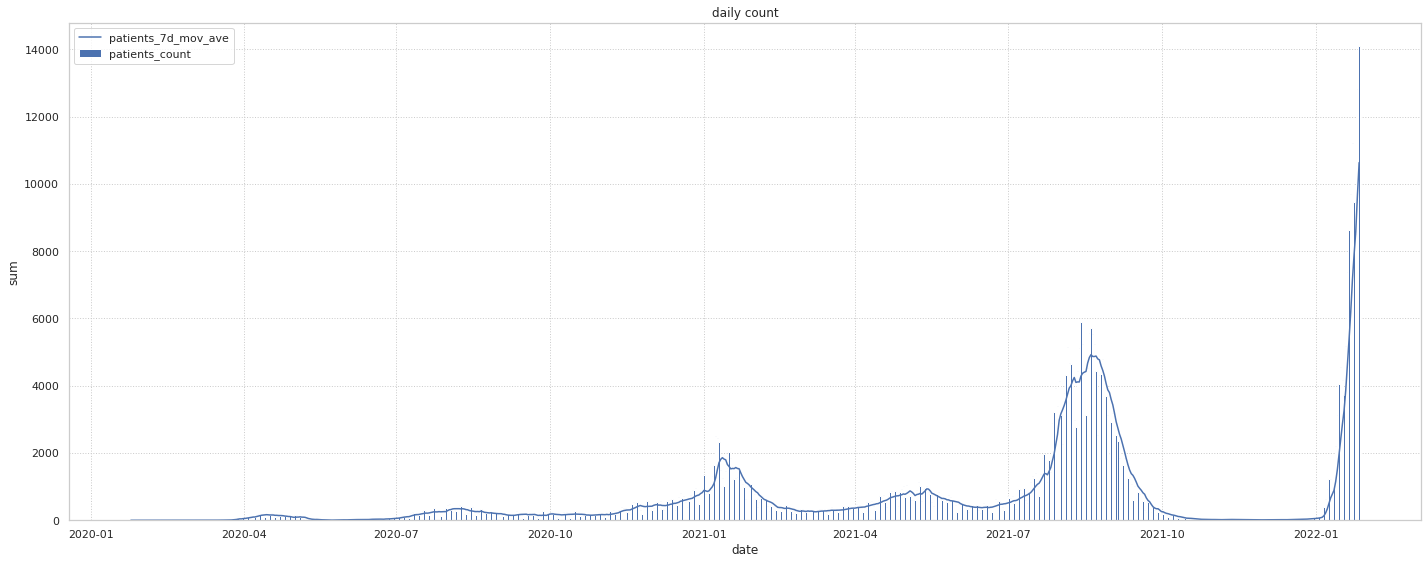

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
719,1.641974e+09,2022,1,12,0,0,0,0,0,0,1,719,0,645,964,652.285714,4566.0,0,0.0,0.0,2198,1148.714286,8041.0
720,1.642061e+09,2022,1,13,0,0,0,0,1,0,0,720,0,646,1125,762.000000,5334.0,0,0.0,0.0,3124,1503.428571,10524.0
721,1.642147e+09,2022,1,14,1,0,0,0,0,0,0,721,0,647,1382,896.142857,6273.0,0,0.0,0.0,4051,1950.428571,13653.0
722,1.642234e+09,2022,1,15,0,0,1,0,0,0,0,722,0,648,1917,1075.285714,7527.0,0,0.0,0.0,4561,2427.142857,16990.0
723,1.642320e+09,2022,1,16,0,0,0,1,0,0,0,723,0,649,1753,1240.428571,8683.0,0,0.0,0.0,4172,2848.428571,19939.0
724,1.642406e+09,2022,1,17,0,1,0,0,0,0,0,724,0,650,2049,1429.285714,10005.0,0,0.0,0.0,3719,3255.285714,22787.0
725,1.642493e+09,2022,1,18,0,0,0,0,0,1,0,725,0,651,1915,1586.428571,11105.0,0,0.0,0.0,5185,3858.571429,27010.0
726,1.642579e+09,2022,1,19,0,0,0,0,0,0,1,726,0,652,2218,1765.571429,12359.0,0,0.0,0.0,7377,4598.428571,32189.0
727,1.642666e+09,2022,1,20,0,0,0,0,1,0,0,727,0,653,2014,1892.571429,13248.0,0,0.0,0.0,8638,5386.142857,37703.0
728,1.642752e+09,2022,1,21,1,0,0,0,0,0,0,728,0,654,1994,1980.000000,13860.0,0,0.0,0.0,9699,6193.000000,43351.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            734 non-null    float64
 1   year                 734 non-null    int64  
 2   month                734 non-null    int64  
 3   day                  734 non-null    int64  
 4   Fri                  734 non-null    uint8  
 5   Mon                  734 non-null    uint8  
 6   Sat                  734 non-null    uint8  
 7   Sun                  734 non-null    uint8  
 8   Thu                  734 non-null    uint8  
 9   Tue                  734 non-null    uint8  
 10  Wed                  734 non-null    uint8  
 11  passed               734 non-null    int64  
 12  emergency            734 non-null    int64  
 13  em_passed            734 non-null    int64  
 14  contacts_count       734 non-null    int64  
 15  contacts_7d_mov_ave  734 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.340000e+02,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,1.611518e+09,2020.568120,6.497275,15.776567,0.143052,0.143052,0.143052,0.143052,0.141689,0.143052,0.143052,366.500000,0.066757,296.280654,639.630790,631.948391,4423.633515,502.069482,502.069482,3514.486376,679.222071,631.901382,4423.287466
std,1.831955e+07,0.562704,3.462820,8.811917,0.350364,0.350364,0.350364,0.350364,0.348969,0.350364,0.350364,212.031837,0.249772,206.253385,511.678226,487.356787,3411.504252,796.104122,729.901830,5109.312809,1431.608990,1195.650547,8369.565572
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.595686e+09,2020.000000,3.250000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,183.250000,0.000000,109.250000,313.250000,314.535714,2201.750000,0.000000,0.000000,0.000000,43.750000,43.250000,302.750000
50%,1.611518e+09,2021.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,366.500000,0.000000,292.500000,498.500000,490.214286,3431.500000,0.000000,0.000000,0.000000,239.000000,255.285714,1787.000000
75%,1.627351e+09,2021.000000,9.750000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,549.750000,0.000000,475.750000,782.000000,761.607143,5331.250000,1029.750000,1058.821429,7411.750000,590.750000,592.392857,4146.750000
max,1.643184e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,733.000000,1.000000,659.000000,2936.000000,2415.428571,16908.000000,4060.000000,2574.142857,18019.000000,14086.000000,10633.428571,74434.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.871996,0.310481,0.005567,-0.004821,0.000964,-0.002892,-0.000964,4.372372e-18,0.002892,0.004821,1.000000e+00,-0.338916,0.998396,-0.194864,-0.213459,-0.213456,-0.617439,-0.663696,-0.663696,0.374610,0.387557,0.387561
year,8.719963e-01,1.000000,-0.192794,-0.038197,-0.004516,0.002404,0.002404,0.002404,-7.534356e-03,0.002404,0.002404,8.719963e-01,-0.270215,0.877895,-0.102389,-0.126900,-0.126898,-0.637597,-0.695427,-0.695427,0.458052,0.453843,0.453845
month,3.104809e-01,-0.192794,1.000000,0.002260,-0.001365,-0.002489,-0.010361,-0.006987,1.499642e-02,0.000884,0.005382,3.104809e-01,-0.153579,0.295647,-0.192792,-0.182887,-0.182884,0.001636,0.022289,0.022289,-0.145117,-0.110468,-0.110464
day,5.566824e-03,-0.038197,0.002260,1.000000,0.005948,-0.002890,-0.002006,0.004180,-3.444016e-03,0.002855,-0.004657,5.566824e-03,-0.002511,0.006298,0.014357,0.020029,0.020027,0.004052,-0.007053,-0.007053,0.061653,0.057247,0.057244
Fri,-4.820636e-03,-0.004516,-0.001365,0.005948,1.000000,-0.166932,-0.166932,-0.166932,-1.660029e-01,-0.166932,-0.166932,-4.820636e-03,-0.000149,-0.004351,-0.018227,-0.006477,-0.006477,0.026337,-0.000383,-0.000383,0.013226,-0.010230,-0.010232
Mon,9.641271e-04,0.002404,-0.002489,-0.002890,-0.166932,1.000000,-0.166932,-0.166932,-1.660029e-01,-0.166932,-0.166932,9.641271e-04,-0.000149,0.000973,0.036906,0.002747,0.002748,0.105172,-0.000383,-0.000383,-0.065556,0.003352,0.003352
Sat,-2.892381e-03,0.002404,-0.010361,-0.002006,-0.166932,-0.166932,1.000000,-0.166932,-1.660029e-01,-0.166932,-0.166932,-2.892381e-03,-0.000149,-0.002576,0.042461,-0.003396,-0.003395,-0.122157,-0.000383,-0.000383,0.020042,-0.005008,-0.005009
Sun,-9.641271e-04,0.002404,-0.006987,0.004180,-0.166932,-0.166932,-0.166932,1.000000,-1.660029e-01,-0.166932,-0.166932,-9.641271e-04,-0.000149,-0.000802,-0.019993,-0.000604,-0.000603,-0.112575,-0.000383,-0.000383,-0.018491,-0.000604,-0.000604
Thu,4.372372e-18,-0.007534,0.014996,-0.003444,-0.166003,-0.166003,-0.166003,-0.166003,1.000000e+00,-0.166003,-0.166003,1.572097e-18,0.000896,-0.000534,-0.009754,-0.003719,-0.003718,0.033023,0.002305,0.002305,0.022269,-0.012738,-0.012737
Tue,2.892381e-03,0.002404,0.000884,0.002855,-0.166932,-0.166932,-0.166932,-0.166932,-1.660029e-01,1.000000,-0.166932,2.892381e-03,-0.000149,0.002747,-0.011158,0.005715,0.005715,0.041749,-0.000383,-0.000383,-0.005033,0.009312,0.009313


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,1.642838e+09,0,0,1,0,0,0,0,729,0,655,2700,0,11227,7145.285714,50017.0
730,1.642925e+09,0,0,0,1,0,0,0,730,0,656,2446,0,9468,7901.857143,55313.0
731,1.643011e+09,0,1,0,0,0,0,0,731,0,657,2936,0,8503,8585.285714,60097.0
732,1.643098e+09,0,0,0,0,0,1,0,732,0,658,2600,0,12813,9675.000000,67725.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
729,1.642838e+09,729,0,11227,7145.285714,50017.0
730,1.642925e+09,730,0,9468,7901.857143,55313.0
731,1.643011e+09,731,0,8503,8585.285714,60097.0
732,1.643098e+09,732,0,12813,9675.000000,67725.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

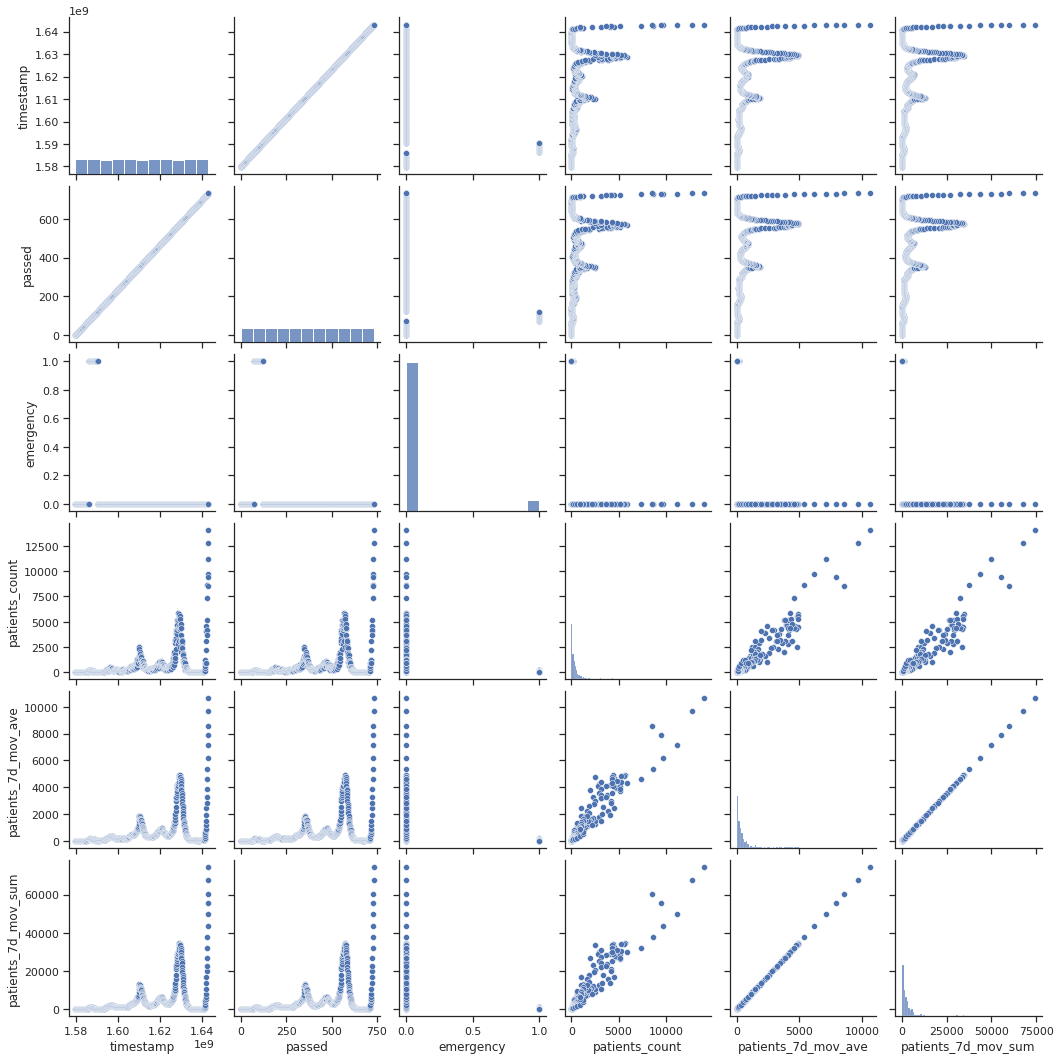

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argcomplete==2.0.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.10
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.26
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dil